In [1]:
# Import all required libraries for data handling, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Try to import XGBoost, LightGBM, and statsmodels if installed
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor
    lgb_available = True
except ImportError:
    lgb_available = False

try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    stats_available = True
except ImportError:
    stats_available = False


In [2]:
# Cell 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Cell 2: Unzip and inspect dataset files
# This cell extracts the zip at '/content/archive (10).zip' into /content/walmart_data/ and lists CSV files found.
import os
import zipfile
zip_path = "/content/archive (10).zip"
extract_dir = "/content/walmart_data/"

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# list CSV files discovered
csv_files = [f for f in os.listdir(extract_dir) if f.lower().endswith('.csv')]
print("CSV files found in archive:", csv_files)


CSV files found in archive: ['features.csv', 'test.csv', 'stores.csv', 'train.csv']


In [5]:
# Cell 3: Load appropriate CSV(s) into DataFrame(s)
# This cell tries to load common Walmart dataset files (train.csv, features.csv, stores.csv).
# If train.csv not found it will try to load the first CSV discovered as fallback.
data_dir = extract_dir
train_path = os.path.join(data_dir, "train.csv")

if os.path.exists(train_path):
    print("Loading train.csv")
    train = pd.read_csv(train_path)
else:
    # fallback: load first csv if train not present
    if len(csv_files) == 0:
        raise FileNotFoundError(f"No CSV files found in {extract_dir}")
    fallback = os.path.join(data_dir, csv_files[0])
    print(f"train.csv not found — using fallback {csv_files[0]}")
    train = pd.read_csv(fallback)

# Show a quick preview
print("Train shape:", train.shape)
display(train.head())


Loading train.csv
Train shape: (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
# Cell 4: Quick EDA — info, missing values, basic stats
# Inspect columns, dtypes, missing values and basic statistical summary.
print("Columns:", train.columns.tolist())
print("\nInfo:")
print(train.info())
print("\nMissing values per column:\n", train.isnull().sum())
display(train.describe(include='all').T)


Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

Missing values per column:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,421570.0,NaN,NaN,NaN,22.200546,12.785297,1.0,11.0,22.0,33.0,45.0
Dept,421570.0,NaN,NaN,NaN,44.260317,30.492054,1.0,18.0,37.0,74.0,99.0
Date,421570,143,2011-12-23,3027,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekly_Sales,421570.0,NaN,NaN,NaN,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36
IsHoliday,421570,2,False,391909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Cell 5: Prepare main DataFrame — ensure Date column present and convert to datetime
# If the dataset uses a different date column name adjust 'Date' below.
if 'Date' not in train.columns:
    # try common alternatives
    possible_date_cols = [c for c in train.columns if 'date' in c.lower()]
    if len(possible_date_cols) > 0:
        train = train.rename(columns={possible_date_cols[0]: 'Date'})
    else:
        raise KeyError("No 'Date' column found in dataset — please rename your date column to 'Date'")

df = train.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date']).reset_index(drop=True)
print("Date range:", df['Date'].min().date(), "to", df['Date'].max().date())


Date range: 2010-02-05 to 2012-10-26


In [8]:
# Cell 6: Create time-based features (year, month, week, dayofweek, quarter, is_month_start/end)
# These features help models capture seasonality and calendar effects.
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.isocalendar().week.astype(int)
df['dayofweek'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter
df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)


In [9]:
# Cell 7: Aggregate option — create a single total-sales time series (or keep per Store/Dept)
# Set AGGREGATE=True to model total weekly sales across dataset, False to work per (Store,Dept).
AGGREGATE = True

if AGGREGATE:
    # If Weekly_Sales column exists, aggregate; otherwise try 'Sales' or similar
    target_col_candidates = [c for c in df.columns if c.lower() in ('weekly_sales','weekly sales','sales','weekly_sales ')]
    if len(target_col_candidates) == 0:
        raise KeyError("No target sales column found (expected 'Weekly_Sales' or similar).")
    target_col = target_col_candidates[0]
    series = df.groupby('Date', as_index=False)[target_col].sum().rename(columns={target_col:'Weekly_Sales'})
    # merge averaged covariates if available
    extras = []
    for col in ['IsHoliday','Temperature','Fuel_Price','CPI','Unemployment','Size']:
        if col in df.columns:
            tmp = df.groupby('Date', as_index=False)[col].mean()
            extras.append(tmp)
    if extras:
        from functools import reduce
        cov = reduce(lambda a,b: a.merge(b, on='Date', how='left'), extras)
        series = series.merge(cov, on='Date', how='left')
    data = series.sort_values('Date').reset_index(drop=True)
    print("Aggregated series shape:", data.shape)
else:
    # Example: choose the longest (Store,Dept) series
    if 'Store' in df.columns and 'Dept' in df.columns:
        gp = df.groupby(['Store','Dept'])['Date'].count().sort_values(ascending=False)
        store, dept = gp.index[0]
        data = df[(df['Store']==store) & (df['Dept']==dept)].sort_values('Date').reset_index(drop=True)
        print(f"Modeling for Store={store}, Dept={dept}, rows={len(data)}")
    else:
        # fallback: use the full df as-is (may be multi-indexed)
        data = df.copy()
        if 'Weekly_Sales' not in data.columns:
            # rename target if necessary
            for c in df.columns:
                if 'sale' in c.lower():
                    data = data.rename(columns={c:'Weekly_Sales'})
                    break
        print("Using full dataset without aggregation; rows:", len(data))


Aggregated series shape: (143, 3)


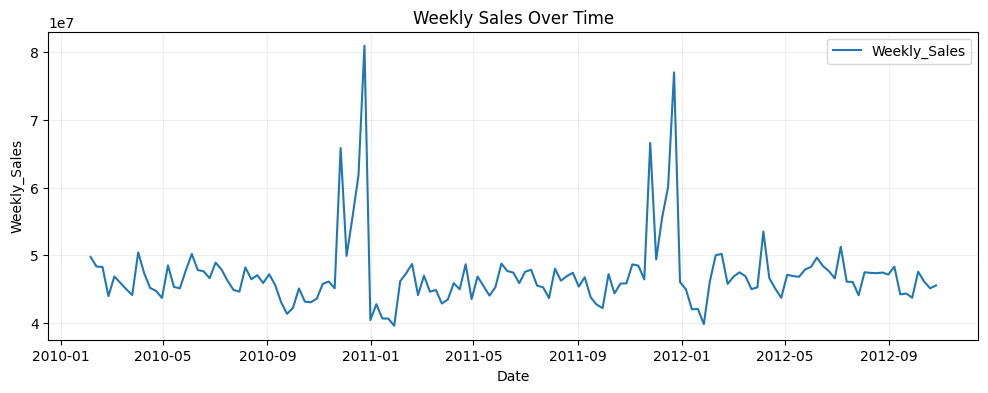

In [10]:
# Cell 8: Plot the target time series (visual check)
# Plot aggregated weekly sales to inspect trend & seasonality
plt.figure(figsize=(12,4))
plt.plot(data['Date'], data['Weekly_Sales'], label='Weekly_Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date'); plt.ylabel('Weekly_Sales')
plt.grid(alpha=0.2); plt.legend()
plt.show()


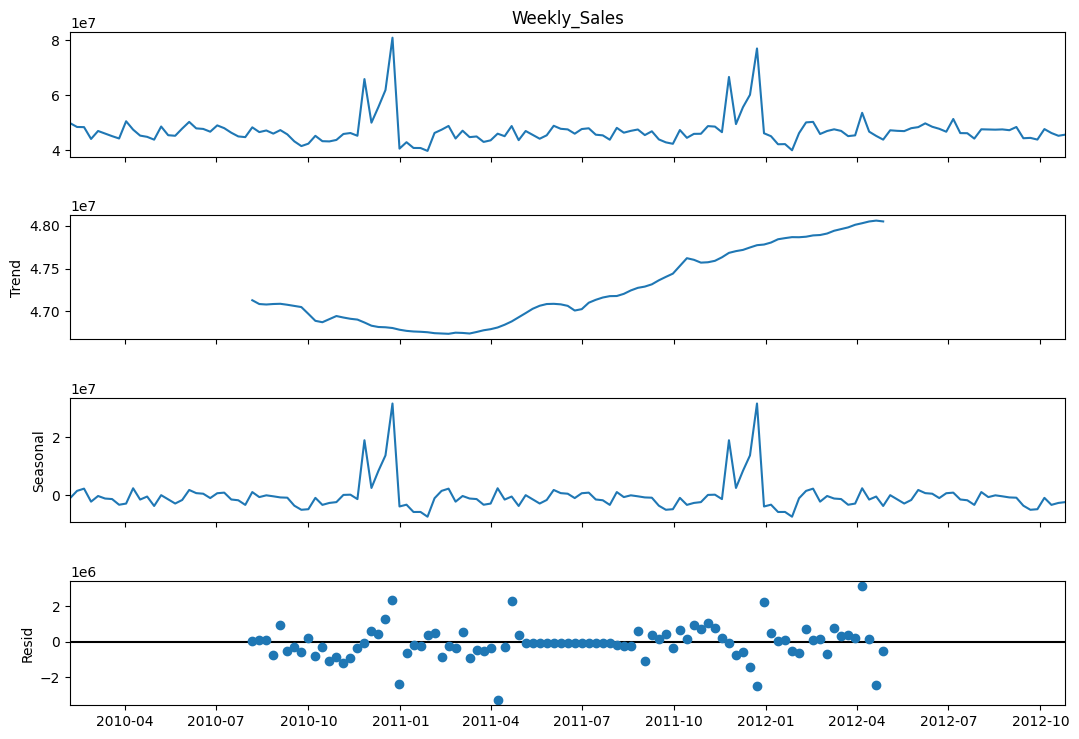

In [11]:
# Cell 9: Seasonal decomposition (BONUS)
# Decompose the (aggregated) weekly series into trend, seasonal and residual components (period=52 weeks).
if stats_available:
    ts = data.set_index('Date')['Weekly_Sales'].asfreq('W-FRI')  # assume weekly frequency with Fridays
    ts = ts.fillna(method='ffill')
    decomp = seasonal_decompose(ts, model='additive', period=52)
    fig = decomp.plot()
    fig.set_size_inches(12,8)
    plt.show()
else:
    print("statsmodels not available — seasonal decomposition skipped (pip install statsmodels).")


In [12]:
# Cell 10: Create lag features (lags: 1,2,4,13,26,52 weeks)
# Lags are created on the modeling series 'data'.
lags = [1,2,4,13,26,52]
for L in lags:
    data[f'lag_{L}'] = data['Weekly_Sales'].shift(L)


In [13]:
# Cell 11: Create rolling mean and rolling std features (BONUS)
# Rolling windows: 4, 8, 13, 26 weeks (shifted by 1 to avoid leakage)
roll_windows = [4,8,13,26]
for W in roll_windows:
    data[f'rollmean_{W}'] = data['Weekly_Sales'].shift(1).rolling(window=W, min_periods=1).mean()
    data[f'rollstd_{W}'] = data['Weekly_Sales'].shift(1).rolling(window=W, min_periods=1).std().fillna(0)


In [14]:
# Cell 12: Add time features to 'data' (year, month, week, dayofweek already present in df; keep relevant)
# For aggregated series, re-create time features from 'Date'.
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['week'] = data['Date'].dt.isocalendar().week.astype(int)
data['dayofweek'] = data['Date'].dt.dayofweek
data['quarter'] = data['Date'].dt.quarter


In [15]:
# Cell 13: Drop rows with NA caused by large lags and reset index
# We must drop rows where lag features are NaN (start of series).
data = data.dropna().reset_index(drop=True)
print("After dropping NA rows, modeling rows:", len(data))


After dropping NA rows, modeling rows: 91


In [16]:
# Cell 14: Define feature columns and target
# Exclude 'Date' and target 'Weekly_Sales' from features.
target = 'Weekly_Sales'
exclude = ['Date', target]
feature_cols = [c for c in data.columns if c not in exclude]
# Optionally drop columns that are not numeric or not desired
# For safety, keep only numeric features
feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(data[c])]
print("Feature columns (sample):", feature_cols[:20])
X = data[feature_cols].copy()
y = data[target].copy()


Feature columns (sample): ['IsHoliday', 'lag_1', 'lag_2', 'lag_4', 'lag_13', 'lag_26', 'lag_52', 'rollmean_4', 'rollstd_4', 'rollmean_8', 'rollstd_8', 'rollmean_13', 'rollstd_13', 'rollmean_26', 'rollstd_26', 'year', 'month', 'week', 'dayofweek', 'quarter']


In [17]:
# Cell 15: Time-aware train/validation/test split
# We'll use the last 12 weeks as validation and the last 4 weeks as holdout/test for final forecast (configurable).
N_VALID = 12
N_TEST = 4

train_end_idx = len(data) - (N_VALID + N_TEST)
valid_end_idx = len(data) - N_TEST

X_train = X.iloc[:train_end_idx]
y_train = y.iloc[:train_end_idx]

X_valid = X.iloc[train_end_idx:valid_end_idx]
y_valid = y.iloc[train_end_idx:valid_end_idx]

X_test = X.iloc[valid_end_idx:]
y_test = y.iloc[valid_end_idx:]

print("Train rows:", len(X_train), "Valid rows:", len(X_valid), "Test rows:", len(X_test))


Train rows: 75 Valid rows: 12 Test rows: 4


In [18]:
# Cell 16: Define evaluation helper (MAE, RMSE, R2)
from math import sqrt
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


In [19]:
# Cell 17: Baseline — Naive forecast using lag_1
# Predict validation and test by using shift-1 (last observed week).
naive_valid = X_valid['lag_1'].values
naive_test = X_test['lag_1'].values

print("Naive Valid eval (MAE, RMSE, R2):", evaluate(y_valid, naive_valid))
print("Naive Test eval (MAE, RMSE, R2):", evaluate(y_test, naive_test))


Naive Valid eval (MAE, RMSE, R2): (1423267.6200000022, 2247341.0413730675, -1.072425530212897)
Naive Test eval (MAE, RMSE, R2): (1674418.5925000012, 2117812.241162865, -4.251654043042477)


In [20]:
# Cell 18: Train classical models — Ridge and RandomForest (with time-aware behavior)
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
pred_ridge_valid = ridge.predict(X_valid)
pred_ridge_test = ridge.predict(X_test)

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf_valid = rf.predict(X_valid)
pred_rf_test = rf.predict(X_test)

print("Ridge Valid:", evaluate(y_valid, pred_ridge_valid))
print("Ridge Test :", evaluate(y_test, pred_ridge_test))
print("RF Valid   :", evaluate(y_valid, pred_rf_valid))
print("RF Test    :", evaluate(y_test, pred_rf_test))


Ridge Valid: (1661953.6858632627, 1731474.5099489724, -0.2301927763017959)
Ridge Test : (3026221.523617048, 3154057.6794772875, -10.64824408967481)
RF Valid   : (729043.1871944399, 908608.0923092599, 0.6612384053600964)
RF Test    : (1113990.2432750147, 1336937.316313139, -1.0928750044385378)


In [21]:
# Cell 19: TimeSeriesSplit cross-validation (walk-forward) on training set (BONUS)
# Evaluate model stability over time (we use 4 splits).
tscv = TimeSeriesSplit(n_splits=4)
cv_rows = []
for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    m = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    m.fit(X_tr, y_tr)
    pr = m.predict(X_va)
    mae, rmse, r2 = evaluate(y_va, pr)
    cv_rows.append({'fold':fold, 'MAE':mae, 'RMSE':rmse, 'R2':r2})

cv_df = pd.DataFrame(cv_rows)
print("Walk-forward CV results:\n", cv_df)
print("CV mean:", cv_df.mean().to_dict())


Walk-forward CV results:
    fold           MAE          RMSE        R2
0     0  1.317778e+06  1.583821e+06 -0.173255
1     1  3.239565e+06  5.875752e+06  0.001578
2     2  3.121951e+06  5.392238e+06  0.623915
3     3  1.991514e+06  2.702590e+06 -0.309389
CV mean: {'fold': 1.5, 'MAE': 2417701.9534291606, 'RMSE': 3888600.0796800335, 'R2': 0.03571221298830135}


In [22]:
# Cell 20: BONUS — Train XGBoost and LightGBM if available (with time-aware validation)
models_results = []

if xgb_available:
    xgb = XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=6, subsample=0.8,
                       colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method='hist')
    xgb.fit(X_train, y_train)
    pred_xgb_valid = xgb.predict(X_valid)
    pred_xgb_test = xgb.predict(X_test)
    print("XGBoost Valid:", evaluate(y_valid, pred_xgb_valid))
    print("XGBoost Test :", evaluate(y_test, pred_xgb_test))
else:
    print("XGBoost not installed — skipping (pip install xgboost)")

if lgb_available:
    lgb = LGBMRegressor(n_estimators=800, learning_rate=0.05, subsample=0.8,
                        colsample_bytree=0.8, random_state=42, n_jobs=-1)
    lgb.fit(X_train, y_train)
    pred_lgb_valid = lgb.predict(X_valid)
    pred_lgb_test = lgb.predict(X_test)
    print("LightGBM Valid:", evaluate(y_valid, pred_lgb_valid))
    print("LightGBM Test :", evaluate(y_test, pred_lgb_test))
else:
    print("LightGBM not installed — skipping (pip install lightgbm)")


XGBoost Valid: (745198.1891666664, 950306.116753948, 0.6294319117664502)
XGBoost Test : (1147256.5500000007, 1486114.5505078596, -1.5859836405002135)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 18
[LightGBM] [Info] Start training from score 47286859.733333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [23]:
# Cell 21: Summarize model performances in a DataFrame (Validation & Test)
rows = []

# Naive
rows.append(['Naive (lag1)', *evaluate(y_valid, naive_valid), *evaluate(y_test, naive_test)])

# Ridge
rows.append(['Ridge', *evaluate(y_valid, pred_ridge_valid), *evaluate(y_test, pred_ridge_test)])

# Random Forest
rows.append(['RandomForest', *evaluate(y_valid, pred_rf_valid), *evaluate(y_test, pred_rf_test)])

# Conditionally add XGBoost / LightGBM if computed
if 'pred_xgb_valid' in globals():
    rows.append(['XGBoost', *evaluate(y_valid, pred_xgb_valid), *evaluate(y_test, pred_xgb_test)])
if 'pred_lgb_valid' in globals():
    rows.append(['LightGBM', *evaluate(y_valid, pred_lgb_valid), *evaluate(y_test, pred_lgb_test)])

cols = ['Model', 'Val_MAE', 'Val_RMSE', 'Val_R2', 'Test_MAE', 'Test_RMSE', 'Test_R2']
results_df = pd.DataFrame(rows, columns=cols)
results_df = results_df.sort_values('Test_RMSE').reset_index(drop=True)
display(results_df)


,Model,Val_MAE,Val_RMSE,Val_R2,Test_MAE,Test_RMSE,Test_R2
0,RandomForest,7.290432e+05,9.086081e+05,0.661238,1.113990e+06,1.336937e+06,-1.092875
1,XGBoost,7.451982e+05,9.503061e+05,0.629432,1.147257e+06,1.486115e+06,-1.585984
2,Naive (lag1),1.423268e+06,2.247341e+06,-1.072426,1.674419e+06,2.117812e+06,-4.251654
3,Ridge,1.661954e+06,1.731475e+06,-0.230193,3.026222e+06,3.154058e+06,-10.648244
4,LightGBM,3.913739e+06,4.600567e+06,-7.684878,2.665028e+06,3.604688e+06,-14.214462


Best model (by Test_RMSE): RandomForest


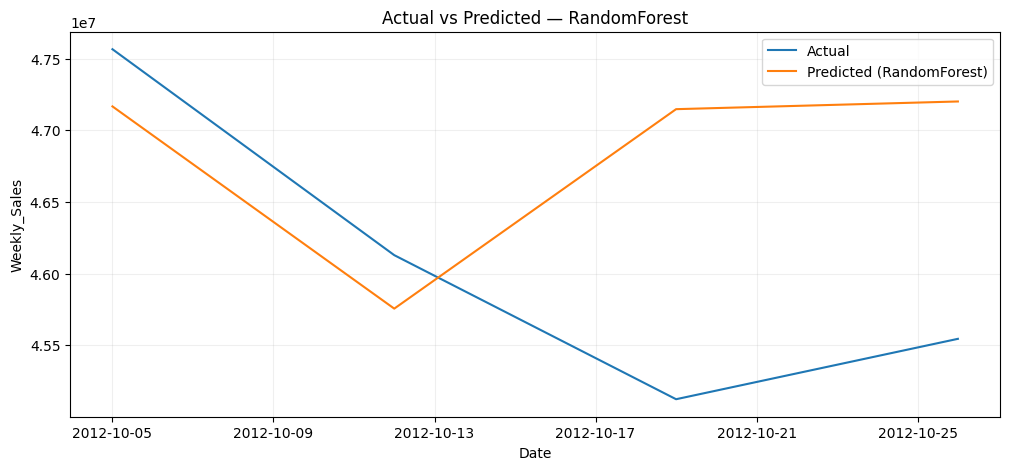

In [24]:
# Cell 22: Plot Actual vs Predicted over time for the best model on TEST set
# Choose best by Test_RMSE from results_df
best_model_name = results_df.loc[0,'Model']
print("Best model (by Test_RMSE):", best_model_name)

# Map name to prediction array
pred_map = {
    'Naive (lag1)': naive_test,
    'Ridge': pred_ridge_test,
    'RandomForest': pred_rf_test
}
if 'pred_xgb_test' in globals(): pred_map['XGBoost'] = pred_xgb_test
if 'pred_lgb_test' in globals(): pred_map['LightGBM'] = pred_lgb_test

best_pred = pred_map[best_model_name]

plt.figure(figsize=(12,5))
plt.plot(data['Date'].iloc[-len(y_test):], y_test.values, label='Actual')
plt.plot(data['Date'].iloc[-len(y_test):], best_pred, label=f'Predicted ({best_model_name})')
plt.title(f'Actual vs Predicted — {best_model_name}')
plt.xlabel('Date'); plt.ylabel('Weekly_Sales')
plt.legend(); plt.grid(alpha=0.2)
plt.show()


In [28]:
# Cell 23: Forecast the next period (next week) using the BEST model
# This cell constructs the next-row features from the last rows (lags and rolling windows).
from datetime import timedelta   # <-- Add this import

last_date = data['Date'].max()
next_date = last_date + timedelta(weeks=1)
print("Last date in data:", last_date.date(), "| Forecasting for:", next_date.date())

# Build an extended history and compute features same as before
hist = data.copy().sort_values('Date').reset_index(drop=True)
# append placeholder row
placeholder = hist.iloc[[-1]].copy()
placeholder['Date'] = next_date
placeholder['Weekly_Sales'] = np.nan
hist_ext = pd.concat([hist, placeholder], ignore_index=True)

# recompute lags and rolls on hist_ext
for L in lags:
    hist_ext[f'lag_{L}'] = hist_ext['Weekly_Sales'].shift(L)
for W in roll_windows:
    hist_ext[f'rollmean_{W}'] = hist_ext['Weekly_Sales'].shift(1).rolling(window=W, min_periods=1).mean()
    hist_ext[f'rollstd_{W}'] = hist_ext['Weekly_Sales'].shift(1).rolling(window=W, min_periods=1).std().fillna(0)

# time features
hist_ext['year'] = hist_ext['Date'].dt.year
hist_ext['month'] = hist_ext['Date'].dt.month
hist_ext['week'] = hist_ext['Date'].dt.isocalendar().week.astype(int)
hist_ext['dayofweek'] = hist_ext['Date'].dt.dayofweek
hist_ext = hist_ext.reset_index(drop=True)

next_row = hist_ext.iloc[[-1]]
# keep same feature columns as training
for col in feature_cols:
    if col not in next_row:
        next_row[col] = 0
next_row = next_row[feature_cols]

# pick best model object
best_obj = None
if best_model_name == 'RandomForest':
    best_obj = rf
elif best_model_name == 'Ridge':
    best_obj = ridge
elif best_model_name == 'XGBoost' and 'xgb' in globals():
    best_obj = xgb
elif best_model_name == 'LightGBM' and 'lgb' in globals():
    best_obj = lgb
elif best_model_name == 'Naive (lag1)':
    next_pred_val = next_row['lag_1'].values[0]
    print("Naive forecast for next week:", next_pred_val)
else:
    best_obj = rf  # fallback

if best_obj is not None:
    next_pred_val = best_obj.predict(next_row.values)[0]
    print(f"Forecast for {next_date.date()}: {next_pred_val:.2f}")


Last date in data: 2012-10-26 | Forecasting for: 2012-11-02
Forecast for 2012-11-02: 48031464.04


In [29]:
# Cell 24: Save results and model artifacts (optional)
# Save validation/test predictions and the final forecast to CSV for later inspection.
out = pd.DataFrame({
    'Date': data['Date'].iloc[-len(y_test):].values,
    'Actual': y_test.values,
    'Predicted': best_pred
})
out_path = "/content/validation_test_predictions.csv"
out.to_csv(out_path, index=False)
print("Saved validation/test predictions to:", out_path)

# Save final forecast
forecast_df = pd.DataFrame({'Date':[next_date], 'Forecast':[next_pred_val]})
forecast_df.to_csv("/content/next_week_forecast.csv", index=False)
print("Saved next-week forecast to: /content/next_week_forecast.csv")


Saved validation/test predictions to: /content/validation_test_predictions.csv
Saved next-week forecast to: /content/next_week_forecast.csv
